In [5]:
using Images, FileIO

In [6]:
# todo: demonstrate the FFT version of this that we'll actually use in hardware
costable = [cos((2x+1)*u*pi/16) for x=0:7, u=0:7]

function dct2_scale(v, u)
    m = u == 0 ? 1/sqrt(2) : 1
    m *= v == 0 ? 1/sqrt(2) : 1
end

function dct2(s)
    [1/4 * dct2_scale(v,u) * 
        sum(Int8(s[y+1,x+1]*255 - 128) * costable[x+1,u+1] * costable[y+1,v+1] 
            for x=0:7, y=0:7) for v=0:7, u=0:7]
end

function idct2(S)
    [1/4 * 
        sum(dct2_scale(v, u) * S[v+1,u+1]
            * costable[x+1,u+1] * costable[y+1,v+1]
            for u=0:7, v=0:7)
    for y=0:7, x=0:7]
end

idct2 (generic function with 1 method)

In [7]:
costable

8×8 Array{Float64,2}:
 1.0   0.980785   0.92388    0.83147   …   0.55557    0.382683   0.19509
 1.0   0.83147    0.382683  -0.19509      -0.980785  -0.92388   -0.55557
 1.0   0.55557   -0.382683  -0.980785      0.19509    0.92388    0.83147
 1.0   0.19509   -0.92388   -0.55557       0.83147   -0.382683  -0.980785
 1.0  -0.19509   -0.92388    0.55557      -0.83147   -0.382683   0.980785
 1.0  -0.55557   -0.382683   0.980785  …  -0.19509    0.92388   -0.83147
 1.0  -0.83147    0.382683   0.19509       0.980785  -0.92388    0.55557
 1.0  -0.980785   0.92388   -0.83147      -0.55557    0.382683  -0.19509

In [52]:
q_table = [ 16  11  10  16  24  40  51  61;
            12  12  14  19  26  58  60  55;
            14  13  16  24  40  57  69  56;
            14  17  22  29  51  87  80  62;
            18  22  37  56  68 109 103  77;
            24  35  55  64  81 104 113  92;
            49  64  78  87 103 121 120 101;
            72  92  95  98 112 100 103  99 ]

q_factor = 1

function quantize(S)
    Int16.(round.(S ./ q_table ./ q_factor))
end

function unquantize(S)
    S .* q_table .* q_factor
end

unquantize (generic function with 1 method)

In [9]:
struct ZigZagIter
    xs
end

function Base.iterate(it :: ZigZagIter)
    (it.xs[1, 1], (1,2,:downleft))
end

function Base.iterate(it :: ZigZagIter, (i, j, s))
    if (i, j) > size(it.xs)
        return nothing
    end
    
    ii = i
    jj = j
    ss = s
    
    if s == :downleft
        if i == size(it.xs)[1]
            jj = j + 1
            ss = :upright
        elseif j == 1
            ii = i + 1
            ss = :upright
        else
            ii = i + 1
            jj = j - 1
        end
    elseif s == :upright
        if j == size(it.xs)[2]
            ii = i + 1
            ss = :downleft
        elseif i == 1
            jj = j + 1
            ss = :downleft
        else
            ii = i - 1
            jj = j + 1
        end
    end
    
    (it.xs[i, j], (ii, jj, ss))
end

function Base.length(it :: ZigZagIter)
    length(it.xs)
end

In [10]:
function rle(S)
    num = 0    
    out = []
    
    for x = ZigZagIter(S)       
        if x == 0
            num += 1
        else
            while num > 15
                num -= 16
                push!(out, (15, 0))
            end
            push!(out, (num, x))            
            num = 0
        end
    end
    
    if num != 0
        push!(out, (0,0))
    end
    
    out
end

rle (generic function with 1 method)

In [11]:
function img_blocks(i)
    ys, xs = size(i)
    [@view i[y:y+7, x:x+7] for y=1:8:ys, x=1:8:xs]
end

function img_from_blocks(bs)
    sz = size(bs)
    r = zeros(sz .* 8)
    for j=1:sz[2]
        for i=1:sz[1]
            r[i*8-7:i*8,j*8-7:j*8] = bs[i,j]
        end
    end
    r
end

img_from_blocks (generic function with 1 method)

In [12]:
function uncompressed_bytes(i)
    vec(UInt8.(i * 255))
end

uncompressed_bytes (generic function with 1 method)

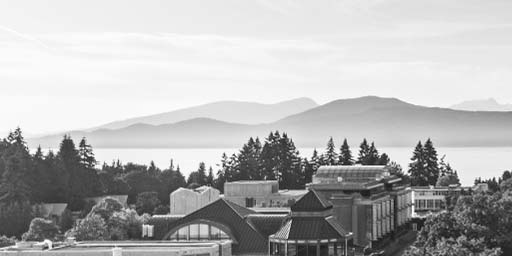

In [13]:
orig_img = load(download("https://www.ubc.ca/_assets/img/about-ubc/about_ubc-1200x438.jpg"))
orig_img = Gray.(orig_img[33:32+256, 33:32+512])

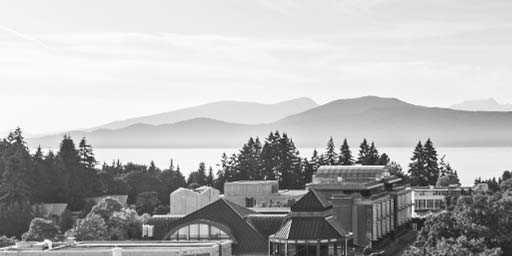

In [53]:
blocks = img_blocks(orig_img)
blocks_S = quantize.(dct2.(blocks))
blocks_recovered = idct2.(unquantize.(blocks_S))
Gray.((img_from_blocks(blocks_recovered) .+ 128) ./ 255)

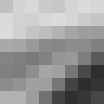

In [54]:
b = blocks[25,38]

In [55]:
d = dct2(b)

8×8 Array{Float64,2}:
 192.125      151.885     -40.1432    …  -0.168136   -0.555136   -0.222264
 311.775     -116.928      27.181        -0.0867596   0.101791    0.112104
  63.6256      35.9194     29.9376       -0.450575   -0.109835   -0.189007
 -11.8887     -55.1929    -72.0239       -0.100551   -0.155334    0.240656
 -34.125      -29.8708     56.7594       -0.790312    0.16682     0.106531
 -20.9         19.119       0.365307  …  -0.450711   -0.0585256   0.134314
  -0.241893    18.2093      0.640165      0.207801    0.0623692   0.168752
  -0.156088    -0.456809    0.3184       -0.477362   -0.315316   -0.0880349

In [56]:
q = quantize(d)

8×8 Array{Int16,2}:
 12   14  -4   0   0  0  0  0
 26  -10   2   1  -1  0  0  0
  5    3   2  -2   0  0  0  0
 -1   -3  -3   1   0  0  0  0
 -2   -1   2   0   0  0  0  0
 -1    1   0   0   0  0  0  0
  0    0   0   0   0  0  0  0
  0    0   0   0   0  0  0  0

In [57]:
rle(q)

22-element Array{Any,1}:
 (0, 12)
 (0, 14)
 (0, 26)
 (0, 5)
 (0, -10)
 (0, -4)
 (1, 2)
 (0, 3)
 (0, -1)
 (0, -2)
 (0, -3)
 (0, 2)
 (0, 1)
 (2, -1)
 (0, -2)
 (0, -3)
 (0, -1)
 (0, -1)
 (1, 1)
 (0, 2)
 (0, 1)
 (0, 0)

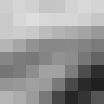

In [58]:
Gray.((idct2(unquantize(q)) .+ 128) ./ 256)

In [23]:
UInt8.(round.(b .* 255))

8×8 Array{UInt8,2}:
 0xc1  0xd4  0xd8  0xca  0xc7  0xd4  0xdb  0xd6
 0xd9  0xd2  0xd0  0xd7  0xdb  0xd6  0xcc  0xc5
 0xdb  0xd0  0xc5  0xbe  0xb3  0xa5  0x9d  0x9c
 0xa9  0xa7  0x9a  0x89  0x86  0x8d  0x8b  0x81
 0x84  0x7f  0x7a  0x82  0x95  0x99  0x7d  0x5a
 0x80  0x7e  0x8e  0xa6  0xa1  0x77  0x48  0x2e
 0x8b  0x93  0xa0  0x9e  0x77  0x43  0x2d  0x33
 0xb1  0xb1  0x9d  0x71  0x43  0x2f  0x37  0x46